In [23]:
import cv2
import json
from matplotlib import pyplot as plt
import numpy as np
import os

# import a lot of things from keras:
# sequential model
from keras.models import Sequential

# layers
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, RandomFlip, RandomRotation, RandomContrast, RandomBrightness

# loss function
from keras.metrics import categorical_crossentropy

# callback functions
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# convert data to categorial vector representation
from keras.utils import to_categorical

# nice progress bar for loading data
from tqdm.notebook import tqdm

# helper function for train/test split
from sklearn.model_selection import train_test_split

# import confusion matrix helper function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [24]:
IMG_SIZE = 64
COLOR_CHANNELS = 1
CONDITIONS = ['dislike', 'like', 'peace', 'rock', 'stop']
PATH = '../../gesture_dataset_sample'

In [6]:
def preprocess_image(img):
    if COLOR_CHANNELS == 1:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    return img_resized

---
## Load train and validation data

In [4]:
annotations_train = dict()

for condition in CONDITIONS:
    with open(f'{PATH}/_annotations/{condition}.json') as f:
        annotations_train[condition] = json.load(f)

In [7]:
images = [] # stores actual image data
labels = [] # stores labels (as integer - because this is what our network needs)
label_names = [] # maps label ints to their actual categories so we can understand predictions later

# loop over all conditions
# loop over all files in the condition's directory
# read the image and corresponding annotation
# crop image to the region of interest
# preprocess image
# store preprocessed image and label in corresponding lists
for condition in CONDITIONS:
    for filename in os.listdir(f'{PATH}/{condition}'):
        # extract unique ID from file name
        UID = filename.split('.')[0]
        img = cv2.imread(f'{PATH}/{condition}/{filename}')
        
        # get annotation from the dict we loaded earlier
        try:
            annotation = annotations_train[condition][UID]
        except Exception as e:
            print(e)
            continue
        
        # iterate over all hands annotated in the image
        for i, bbox in enumerate(annotation['bboxes']):
            # annotated bounding boxes are in the range from 0 to 1
            # therefore we have to scale them to the image size
            x1 = int(bbox[0] * img.shape[1])
            y1 = int(bbox[1] * img.shape[0])
            w = int(bbox[2] * img.shape[1])
            h = int(bbox[3] * img.shape[0])
            x2 = x1 + w
            y2 = y1 + h
            
            # crop image to the bounding box and apply pre-processing
            crop = img[y1:y2, x1:x2]
            preprocessed = preprocess_image(crop)
            
            # get the annotated hand's label
            # if we have not seen this label yet, add it to the list of labels
            label = annotation['labels'][i]
            if label not in label_names and label:
                label_names.append(label)
            
            label_index = label_names.index(label)
            
            images.append(preprocessed)
            labels.append(label_index)

In [9]:
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

images = np.array(images).astype('float32')
images = images / 255.

X_val = np.array(X_val).astype('float32')
X_val = X_val / 255.

y_train_one_hot = to_categorical(labels)
y_val_one_hot = to_categorical(y_val)

train_label = y_train_one_hot
val_label = y_val_one_hot

images = images.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)
X_val = X_val.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)

(1627, 64, 64, 1) (326, 64, 64, 1) (1627, 6) (326, 6)


---
## Build and train model

In [10]:
# variables for hyperparameters
batch_size = 8
epochs = 50
num_classes = len(label_names)
activation = 'relu'
activation_conv = 'LeakyReLU'  # LeakyReLU
layer_count = 2
num_neurons = 64

# define model structure
# with keras, we can use a model's add() function to add layers to the network one by one
model = Sequential()

# data augmentation (this can also be done beforehand - but don't augment the test dataset!)
model.add(RandomFlip('horizontal'))
model.add(RandomContrast(0.1))
#model.add(RandomBrightness(0.1))
#model.add(RandomRotation(0.2))

# first, we add some convolution layers followed by max pooling
model.add(Conv2D(64, kernel_size=(9, 9), activation=activation_conv, input_shape=(IMG_SIZE, IMG_SIZE, COLOR_CHANNELS), padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4), padding='same'))

model.add(Conv2D(32, (5, 5), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))

model.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# dropout layers can drop part of the data during each epoch - this prevents overfitting
model.add(Dropout(0.2))

# after the convolution layers, we have to flatten the data so it can be fed into fully connected layers
model.add(Flatten())

# add some fully connected layers ("Dense")
for i in range(layer_count - 1):
    model.add(Dense(num_neurons, activation=activation))

model.add(Dense(num_neurons, activation=activation))

# for classification, the last layer has to use the softmax activation function, which gives us probabilities for each category
model.add(Dense(num_classes, activation='softmax'))

# specify loss function, optimizer and evaluation metrics
# for classification, categorial crossentropy is used as a loss function
# use the adam optimizer unless you have a good reason not to
model.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

# define callback functions that react to the model's behavior during training
# in this example, we reduce the learning rate once we get stuck and early stopping
# to cancel the training if there are no improvements for a certain amount of epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

2023-06-11 18:57:28.039898: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-11 18:57:28.516003: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [11]:
history = model.fit(
    images,
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_val, val_label),
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/50
204/204 [==============================] - 13s 54ms/step - loss: 1.7914 - accuracy: 0.2207 - val_loss: 1.7602 - val_accuracy: 0.2607 - lr: 0.0010
Epoch 2/50
204/204 [==============================] - 37s 179ms/step - loss: 1.5614 - accuracy: 0.3614 - val_loss: 1.2231 - val_accuracy: 0.5245 - lr: 0.0010
Epoch 3/50
204/204 [==============================] - 19s 95ms/step - loss: 1.0464 - accuracy: 0.6066 - val_loss: 0.6829 - val_accuracy: 0.7791 - lr: 0.0010
Epoch 4/50
204/204 [==============================] - 15s 74ms/step - loss: 0.6109 - accuracy: 0.7855 - val_loss: 0.5082 - val_accuracy: 0.8098 - lr: 0.0010
Epoch 5/50
204/204 [==============================] - 14s 67ms/step - loss: 0.4668 - accuracy: 0.8267 - val_loss: 0.3448 - val_accuracy: 0.8650 - lr: 0.0010
Epoch 6/50
204/204 [==============================] - 13s 63ms/step - loss: 0.3848 - accuracy: 0.8623 - val_loss: 0.3261 - val_accuracy: 0.8773 - lr: 0.0010
Epoch 7/50
204/204 [==============================] - 12s

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 64, 64, 1)         0         
                                                                 
 random_contrast (RandomCont  (None, 64, 64, 1)        0         
 rast)                                                           
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 64)        5248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        51232     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 32)         0

In [13]:
model.save('gesture_recognition_own')

2023-06-11 19:03:17.194465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'random_flip_input' with dtype float and shape [?,64,64,1]
	 [[{{node random_flip_input}}]]
2023-06-11 19:03:17.388867: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64,64,1]
	 [[{{node inputs}}]]
2023-06-11 19:03:17.433351: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'random_flip_input' with dtype float and shape [?,64

INFO:tensorflow:Assets written to: gesture_recognition_own/assets


INFO:tensorflow:Assets written to: gesture_recognition_own/assets


---
---

If you dont want to fit the model (again), just load it :)

In [27]:
from keras.models import load_model
model = load_model("gesture_recognition_own")

---
---

## Load test data
Use own data set here

In [25]:
annotations_test = dict()

with open(f'annot_emmert.json') as f:
    annotations_test = json.load(f)

In [28]:
X_test = [] # stores actual image data
y_test = [] # stores labels (as integer - because this is what our network needs)

# loop over all img files 
# read the image and corresponding annotation
# crop image to the region of interest
# preprocess image
# store preprocessed image and label in corresponding lists
PATH = 'images_resized'
for filename in os.listdir(f'{PATH}'):
    # extract unique ID from file name
    UID = filename.split('.')[0]
    img = cv2.imread(f'{PATH}/{filename}')
    
    # get annotation from the dict we loaded earlier
    try:
        annotation = annotations_test[UID]
    except Exception as e:
        print(e)
        continue
    
    # iterate over all hands annotated in the image
    for i, bbox in enumerate(annotation['bboxes']):
        # annotated bounding boxes are in the range from 0 to 1
        # therefore we have to scale them to the image size
        x1 = int(bbox[0] * img.shape[1])
        y1 = int(bbox[1] * img.shape[0])
        w = int(bbox[2] * img.shape[1])
        h = int(bbox[3] * img.shape[0])
        x2 = x1 + w
        y2 = y1 + h
        
        # crop image to the bounding box and apply pre-processing
        crop = img[y1:y2, x1:x2]
        preprocessed = preprocess_image(crop)
        
        # get the annotated hand's label
        label = annotation['labels'][i]       
        label_index = label_names.index(label)
        
        X_test.append(preprocessed)
        y_test.append(label_index)


'edfe9f8b-1e64-4096-bea6-6b247c23d337'
'837e7e35-8b64-4310-8b18-1e269bf649c7'
'57faaaca-e6b4-4b15-9b01-d2000b7922d9'
'ad4eb3aa-11d6-4b0c-ba2b-c207b3714858'
'1fc87099-6b91-4c0f-8971-0a2ea06bbc0a'
'c91cd070-3f7a-4de2-b597-7cba60c9bbcd'
'b13f05fd-5133-4f12-9ae8-3aecb4bb01d6'


In [29]:
X_test = np.array(X_test).astype('float32')
X_test = X_test / 255.
y_test_one_hot = to_categorical(y_test)
test_label = y_test_one_hot
X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)

---
# Prediction for test data

1/1 [==============================] - 0s 123ms/step


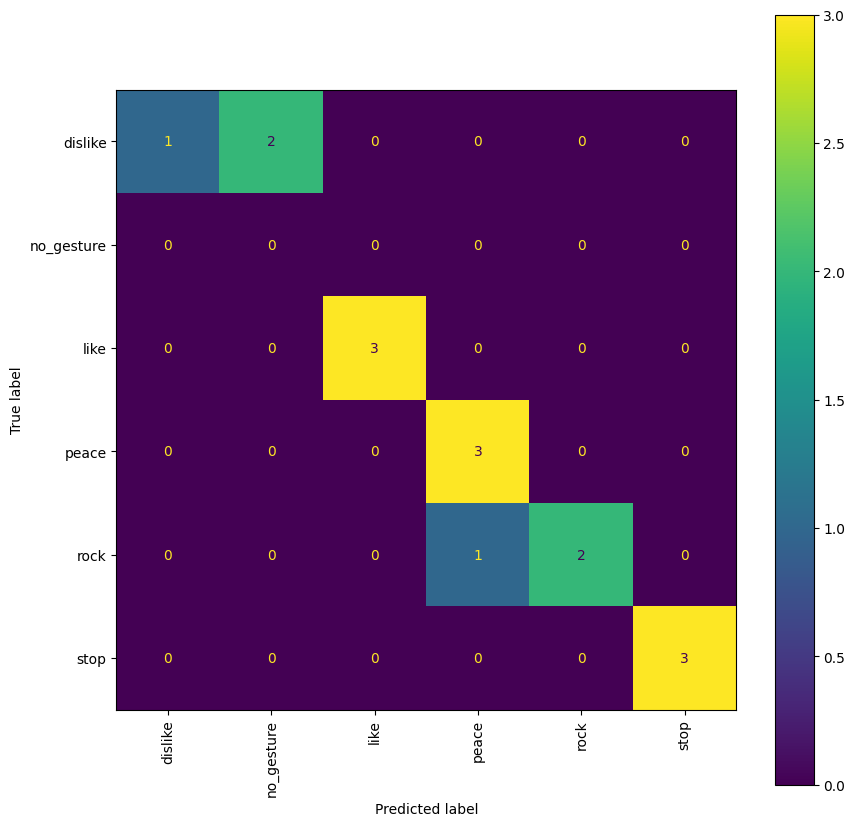

In [30]:
# let the model make predictions for own image data
y_predictions = model.predict(X_test)
y_predictions = np.argmax(y_predictions, axis=1)

conf_matrix = confusion_matrix(y_test, y_predictions)

try:
    fig = plt.figure(figsize=(10, 10))
    ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())
    plt.xticks(rotation=90, ha='center')
    pass
except:
    print("Ignoring no_gesture-label.")